In [ ]:
import numpy as np
import pandas
import pandas_profiling
import matplotlib.pyplot as plt
import gymnasium
import gym
import random
import time
from gymnasium.wrappers import RecordVideo
import tensorflow as tf
from collections import namedtuple, deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam
from gymnasium.experimental.wrappers import GrayscaleObservationV0, FrameStackObservationV0
from tensorflow.keras.losses import MSE 

In [ ]:
#  sets the precision to 3 decimal places.
np.set_printoptions(precision=3)

# Enviroment Setup (Mode 2 is the real game)
Game Mode 0 (default) - 15

Changing the Game Mode (Good For Testing Generalisation of the model) 

In [ ]:
mode = 0
env = gym.make("SpaceInvaders-ram-v0", mode=mode)
env.metadata['render_fps'] = 24

# Enviroment Insights

undestanding the dimensions of the data

In [ ]:
ram_space = env.observation_space.shape
actions = env.action_space.n
print(ram_space)
print(actions)

In [ ]:
env.unwrapped.get_action_meanings()

# Testing the Env

    Confirmed Working

In [ ]:
""" episodes = 100

for episode in range(0, episodes+1):
    env.close()
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = random.choice([0,1,2,3,4,5])
        new_state, reward, done, _, info = env.step(action)
        score+=reward
    
    if(episode > 0):
        print('Episode:{} Score:{}'.format(episode, score))
 """

# Why Deep Q-Learning

We discovered with Q-learning that it was not possible to train the agent with the Q-Learning algorithm due to the limitations of the Q-Table. The state returned by env.reset() and env.step(action) in the Atari environments is a full image from the game screen. Pixel values range from 0 to 255, and most of them will not correspond to valid indices in your Q-table.

Therefore we will utilize Deep Q-Learning to solve this issue.

## Creating a Deep Learning Model with Keras

In [ ]:
q_net = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="elu", input_shape=ram_space),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(actions)
])

In [ ]:
q_net.summary()

In [ ]:
target_q_net = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="elu", input_shape=ram_space),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(actions)
])

In [ ]:
target_q_net.summary()

# Implementing DQN

In [ ]:
BUFFER_SIZE = 100_000
GAMMA = 0.995 # discount factor
ALPHA = 0.001 # learning rate
TAU = 0.001 # soft update factor

STEPS_BETWEEN_LEARNING = 4
MINI_BATCH_SIZE = 64

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=ALPHA)

In [ ]:
from collections import namedtuple, deque
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [ ]:
def loss(experiences, gamma, q_net, target_q_net):
    '''
    y_j = R_j if episode terminates at T_{j+1}, else
    y_j = R_j + gamma max_{a'} Q^(s_{j+1}, a')
    '''
    # unpack experiences into its components
    states, actions, rewards, next_states, done_vals = experiences
    
    # compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_net(next_states), axis=-1)
    
    # y = R if episode terminates, else y = R + y max Q^(s,a)
    # note: done_vals is boolean, and (1 - done_vals) == 0 if done_vals == True
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    
    q_values = q_net(states)
    # tf.gather_nd(params, indices) returns `indices` slices of `params`
    q_values = tf.gather_nd(q_values, 
                            tf.stack([tf.range(q_values.shape[0]),
                                      tf.cast(actions, tf.int32)],
                                     axis=1
                                    ))
    
    # compute MSE loss
    return MSE(y_targets, q_values)

In [ ]:
@tf.function
def learn(experiences, gamma):
    """
    Fit the Q and Q target networks
    """
    
    # compute loss
    with tf.GradientTape() as tape:
        computed_loss = loss(experiences, gamma, q_net, target_q_net)
        
    # update q_net
    gradients = tape.gradient(computed_loss, q_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, q_net.trainable_variables))
    
    # update target_q_net
    for target_weights, q_net_weights in zip(target_q_net.weights, q_net.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [16]:
time_begin = time.time()

episodes = 10_000 # how many times we play the game
max_steps = 1000 # how many actions allowed before 'time out'
avg_latest_score_before_save = 400

score_history = []

avg_points = 100

epsilon = 1.0 # initial epsilon for greedy policy (exploration/exploitation)
epsilon_decay = 0.995
epsilon_min = 0.01

buffer = deque(maxlen=BUFFER_SIZE)

# clone q_net into target_q_net
target_q_net.set_weights(q_net.get_weights())

for i in range(episodes):
    state, _ = env.reset()
    score = 0
    done = False
    t = 0
    
    while not done:
        if(t <= max_steps):
            t += 1
        state_qn = np.expand_dims(state, axis=0)
        q_values = q_net(state_qn)
        # make epsilon greedy choice
        if random.random() > epsilon:
            # exploitation
            action = np.argmax(q_values.numpy()[0])
        else:
            # exploration
            action = env.action_space.sample()
        
        # take action and update buffer
        next_state, reward, done, _, _ = env.step(action)
        buffer.append(experience(state, action, reward, next_state, done))
        
        # check whether this is a learning step
        if (t + 1) % STEPS_BETWEEN_LEARNING == 0 and len(buffer) > MINI_BATCH_SIZE:
            # this is a learning step
            experiences = random.sample(buffer, k=MINI_BATCH_SIZE)
            states = tf.convert_to_tensor(
                np.array([e.state for e in experiences if e is not None]),
                dtype=tf.float32)
            actions = tf.convert_to_tensor(
                np.array([e.action for e in experiences if e is not None]), 
                dtype=tf.float32)
            rewards = tf.convert_to_tensor(
                np.array([e.reward for e in experiences if e is not None]), 
                dtype=tf.float32)
            next_states = tf.convert_to_tensor(
                np.array([e.next_state for e in experiences if e is not None]),
                dtype=tf.float32)
            done_vals = tf.convert_to_tensor(
                np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                dtype=tf.float32)
            experiences = states, actions, rewards, next_states, done_vals
            learn(experiences, GAMMA)
            
        state = next_state.copy()
        score += reward
        
        if done: break
        
    score_history.append(score)
    avg_latest_score = np.mean(score_history[-avg_points:])

    # update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # display status
    status_message = f'\rEpisode {i + 1} | Total score average of last {avg_points} episodes: {avg_latest_score:.2f}'
    print(status_message, end='')
    if (i + 1) % 100 == 0:
        print(status_message)

    if avg_latest_score >= avg_latest_score_before_save:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_net.save('crazy_astronaut.h5')
            
time_end = time.time()
runtime = time_end - time_begin
print(f'\nTotal runtime: {runtime:.2f} sec. ({(runtime/60):.2f} min.)')

Episode 850 | Total score average of last 100 episodes: 191.90

KeyboardInterrupt: 

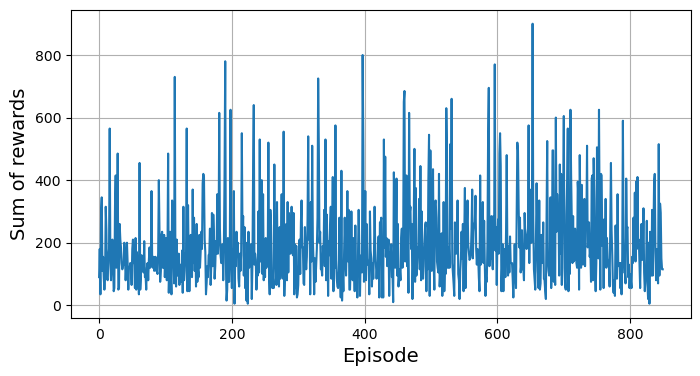

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(score_history)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

Conclusion, training an AI on a game like space invaders takes a long time, due to the fact as the agent surives longer it requires time and energy.

There could utilised different strategies to optimize this process and lowering dimension og set scope to someling like (highest score) in shortes amount of time, as this would like triggers the AI to seek to kill the aliens faster and this would also transition to surviving longer when competing. 

## Build Agent with Keras-RL

## Agent Setup (this need to point the trained agent)

In [ ]:
def agent(env):
    """Random agent that samples actions from the environment's action space."""
    return env.action_space.sample()

# Agent Testing

In [ ]:
""" def get_agent_scores(num_episodes = 1):
    scores = pandas.DataFrame(columns=['score'])
    total_reward = 0
    #highest_score = 0
    
    for _ in range(0, num_episodes + 1):
        #if(_ > 1 and total_reward > 0):
        #    print(f'Game Episode {_ - 1}: Score: {total_reward}')
        env.close()
        total_reward = 0
        observation, info = env.reset()  # Getting start stats from the game
        lives = info['lives']  # Initialize lives inside the loop
        while lives != 0:
            # For demonstration purposes, we use a random agent
            action = agent(env)   # Just a random agent
            obs, reward, terminated, truncated, info = env.step(action)
            lives = info['lives']
            total_reward = total_reward + reward

        # Update highest score if current total reward is higher
        #if total_reward > highest_score:
        #    highest_score = total_reward

        scores = pandas.concat([scores, pandas.DataFrame({'score': [total_reward]})], ignore_index=True)


    """ # Print the highest score achieved
    print(f"Highest Score: {highest_score}") """

    # Close the environment to finalize the video recording
    scores = scores.drop(scores.index[0])
    return scores
 """

In [ ]:
num_episodes = 100

scores = get_agent_scores(num_episodes = num_episodes)



# Descriptive Statistics of Agent Performance

In [ ]:
scores.info()

In [ ]:
scores.head()

In [ ]:
scores.tail()

In [ ]:
scores.describe()

In [ ]:

index_start = 0
index_end = num_episodes-1

print(f"Game Episode 1: Score {scores.iloc[index_start]['score']}\nGame Episode {num_episodes}: Score {scores.iloc[index_end]['score']}")

In [ ]:
print(f"Lowest Score: {scores['score'].min()}\nHigh Score: {scores['score'].max()}")

## Mode (most frequent element)
It is possible for a sample to have multiple modes. In statistics, a mode refers to the value or values in a dataset that occur most frequently. If there are multiple values with the same highest frequency, the dataset is considered multimodal.

In [ ]:
scores.mode()

## Median (middle value of the data set)

In [ ]:
scores.median()

## Mean (average)

In [ ]:
scores.mean()

## Variance (Dissimilarity between samples)

For samples degrees of freedom (ddof) is 0.

Note: The number is high due there is a lot of Dissimilarities between each score.

$$\sigma=\frac{\sum\left(x_i-\mu\right)^2}{n}\text{ for samples (degrees of freedom is 0)}$$ 

In [ ]:
scores.var(ddof=0)

## Standard Deviation ( variability within a sample)
For samples degrees of freedom (ddof) is 0.

$$SD_0=\sqrt{\frac{\sum\left(x_i-\mu\right)^2}{n}}\text{ for samples (degrees of freedom is 0)}$$

In [ ]:

scores.std(ddof=0)

# Report Generation

In [ ]:
report = pandas_profiling.ProfileReport(scores).to_file('test_agent_scores_report.html')